#### Machine Learning Stock Prediction

### 1. Problem Defininition

Option 1:
Explain and extend a REGRESSION case model in:
Machine Learning and Data Science Blueprints for finance by Tatsat.
Usually these systems predict a single asset.
Good cases in Tatsat's book to explain and extend:
Chapter 5 Supervised learning: Regression.

Case study 1: Stock price prediction

In the supervised regression framework used for this case study, weekly log return of the Microsoft stock is the predicted variable. We need to understand what affects Microsoft stock price and hence incorporate as much information into the model then we trade with the predictions of the model and compare the returns to the market returns.

For this case study, other than the historical data of Microsoft, the independent variables used are the following potentially correlated assets, imported data is from 2010-01-01 to 2025-07-01.

- Stocks: IBM (IBM) and Alphabet (GOOGL)
- Currency: USD/JPY and GBP/USD
- Indices: S&P 500, Dow Jones and VIX

### 2. Fetching the python Libraries and Data

#### 2.1 Loading the python packages

In [1]:
# Load libraries
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import talib
import datetime
import shap
import detrendPrice
import WhiteRealityCheckFor1

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor

#Libraries for Deep Learning Models
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from keras.layers import LSTM
from keras.wrappers.scikit_learn import KerasRegressor

#Libraries for Statistical Models
import statsmodels.api as sm
import scipy.stats as stats

#Libraries for Saving the Model
from pickle import dump
from pickle import load

# Error Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Feature Selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression

#Plotting 
from pandas.plotting import scatter_matrix
from statsmodels.graphics.tsaplots import plot_acf

Using TensorFlow backend.


In [2]:
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

### 2.2. Loading the Data

In [3]:
# Tickers from Tatsat's textbook
#['MSFT', 'IBM', 'GOOGL']       # Stocks from Yahoo Finance
#['DEXJPUS', 'DEXUSUK']         # USD/JPY and USD/GBP from FRED
#['SP500', 'DJIA', 'VIXCLS']    # US Indices and Volatility from FRED

# Load data CSV
stk_data = pd.read_csv('stk_data.csv', header=[0, 1], index_col=0, parse_dates=True)
ccy_data = pd.read_csv('ccy_data.csv', index_col=0, parse_dates=True)
idx_data = pd.read_csv('idx_data.csv', index_col=0, parse_dates=True)

In [4]:
# Setting the return period to make it on a weekly basis
return_period = 5

# Target variable: log return of MSFT Close price
Y = np.log(stk_data.loc[:, ('MSFT', 'Close')]).diff(return_period).shift(-return_period)
Y.name = Y.name[-1] + '_pred'

# Log returns of GOOGL and IBM Close prices
X1 = np.log(stk_data.loc[:, [('GOOGL', 'Close'), ('IBM', 'Close')]]).diff(return_period)
X1.columns = X1.columns.droplevel(1)  # Drop second level: 'Close'
X2 = np.log(ccy_data).diff(return_period)
X3 = np.log(idx_data).diff(return_period)

# Multiple time horizons for MSFT Close price
X4 = pd.concat([np.log(stk_data.loc[:, ('MSFT', 'Close')]).diff(i)
                for i in [return_period, return_period*3, return_period*6, return_period*12]], axis=1).dropna()
X4.columns = ['MSFT_DT', 'MSFT_3DT', 'MSFT_6DT', 'MSFT_12DT']

# Combining all features
X = pd.concat([X1, X2, X3, X4], axis=1)

In [5]:
# Volume log returns
msft_volume = stk_data.loc[:, ('MSFT', 'Volume')]
X['MSFT_Volume_LogRet'] = np.log(msft_volume).diff(return_period)

# Rolling volatility (std dev of MSFT Close log returns, 10-day window)
msft_close_logret = np.log(stk_data.loc[:, ('MSFT', 'Close')]).diff()
X['MSFT_10d_RollVol'] = msft_close_logret.rolling(window=10).std()

# Momentum (MSFT Close price difference over 10 days)
X['MSFT_10d_Momentum'] = stk_data.loc[:, ('MSFT', 'Close')].diff(10)

# RSI (14-day) on MSFT Close price
X['MSFT_RSI_14'] = talib.RSI(stk_data.loc[:, ('MSFT', 'Close')], timeperiod=14)

# ADX (Average Directional Index) over 14 days
X['MSFT_ADX_14'] = talib.ADX(stk_data.loc[:, ('MSFT', 'High')],
                             stk_data.loc[:, ('MSFT', 'Low')],
                             stk_data.loc[:, ('MSFT', 'Close')], timeperiod=14)

dataset = pd.concat([Y, X], axis=1).dropna().iloc[::return_period, :]
Y = dataset.loc[:, Y.name]
X = dataset.loc[:, X.columns]

### 3. Exploratory Data Analysis

#### 3.1. Descriptive Statistics

In [6]:
# Exploring the statistics of the dataset
pd.set_option('precision', 3)
dataset.describe()

,Close_pred,GOOGL,IBM,DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,MSFT_DT,MSFT_3DT,MSFT_6DT,MSFT_12DT,MSFT_Volume_LogRet,MSFT_10d_RollVol,MSFT_10d_Momentum,MSFT_RSI_14,MSFT_ADX_14
count,469.000,469.000,469.000,4.690e+02,4.690e+02,469.000,469.000,4.690e+02,469.000,469.000,469.000,469.000,469.000,469.000,469.000,469.000,469.000
mean,0.004,0.003,0.001,4.781e-04,-6.131e-04,0.002,0.002,-2.590e-04,0.005,0.016,0.030,0.057,0.001,0.015,1.825,55.907,23.967
std,0.035,0.038,0.035,1.280e-02,1.297e-02,0.024,0.024,1.737e-01,0.035,0.055,0.073,0.094,0.429,0.009,11.168,11.163,9.260
min,-0.179,-0.168,-0.231,-6.723e-02,-7.267e-02,-0.198,-0.209,-6.219e-01,-0.179,-0.282,-0.229,-0.298,-1.831,0.002,-47.426,24.706,6.863
25%,-0.014,-0.017,-0.015,-5.493e-03,-7.745e-03,-0.008,-0.007,-8.138e-02,-0.011,-0.010,-0.013,-0.004,-0.260,0.010,-1.401,48.067,17.131
50%,0.006,0.005,0.002,1.323e-03,-6.659e-04,0.005,0.004,-1.214e-02,0.006,0.019,0.036,0.063,0.003,0.014,1.474,55.785,22.752
75%,0.025,0.026,0.020,8.233e-03,6.589e-03,0.015,0.013,7.348e-02,0.025,0.046,0.078,0.122,0.243,0.019,5.955,63.455,29.086
max,0.126,0.124,0.151,4.089e-02,6.246e-02,0.099,0.116,1.141e+00,0.126,0.176,0.264,0.377,1.727,0.089,67.376,83.812,52.014


In [7]:
# Visualizing the dataset
dataset.head()

,Close_pred,GOOGL,IBM,DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,MSFT_DT,MSFT_3DT,MSFT_6DT,MSFT_12DT,MSFT_Volume_LogRet,MSFT_10d_RollVol,MSFT_10d_Momentum,MSFT_RSI_14,MSFT_ADX_14
2015-08-10,-2.110e-04,-0.002,-0.004,0.005,-0.004,2.922e-03,9.638e-04,-0.027,1.105e-02,0.009,0.045,-0.022,-0.044,0.012,1.717,58.927,14.162
2015-08-17,-1.203e-01,0.046,-0.003,-0.002,0.003,-8.273e-04,-3.981e-03,0.063,-2.110e-04,0.043,0.064,-0.002,-0.090,0.012,0.442,57.782,10.781
2015-08-24,4.320e-02,-0.116,-0.086,-0.048,0.008,-1.048e-01,-1.003e-01,1.141,-1.203e-01,-0.110,-0.082,-0.111,1.437,0.022,-4.661,26.520,15.143
2015-08-31,8.466e-03,0.047,0.030,0.023,-0.024,4.087e-02,4.054e-02,-0.360,4.320e-02,-0.077,-0.069,-0.052,-0.947,0.032,-3.046,43.078,21.835
2015-09-08,2.049e-03,-0.006,-0.004,-0.002,0.003,2.862e-02,2.669e-02,-0.232,8.466e-03,-0.069,-0.026,-0.040,-0.059,0.031,1.929,48.067,23.709


#### 3.2. Data Visualization

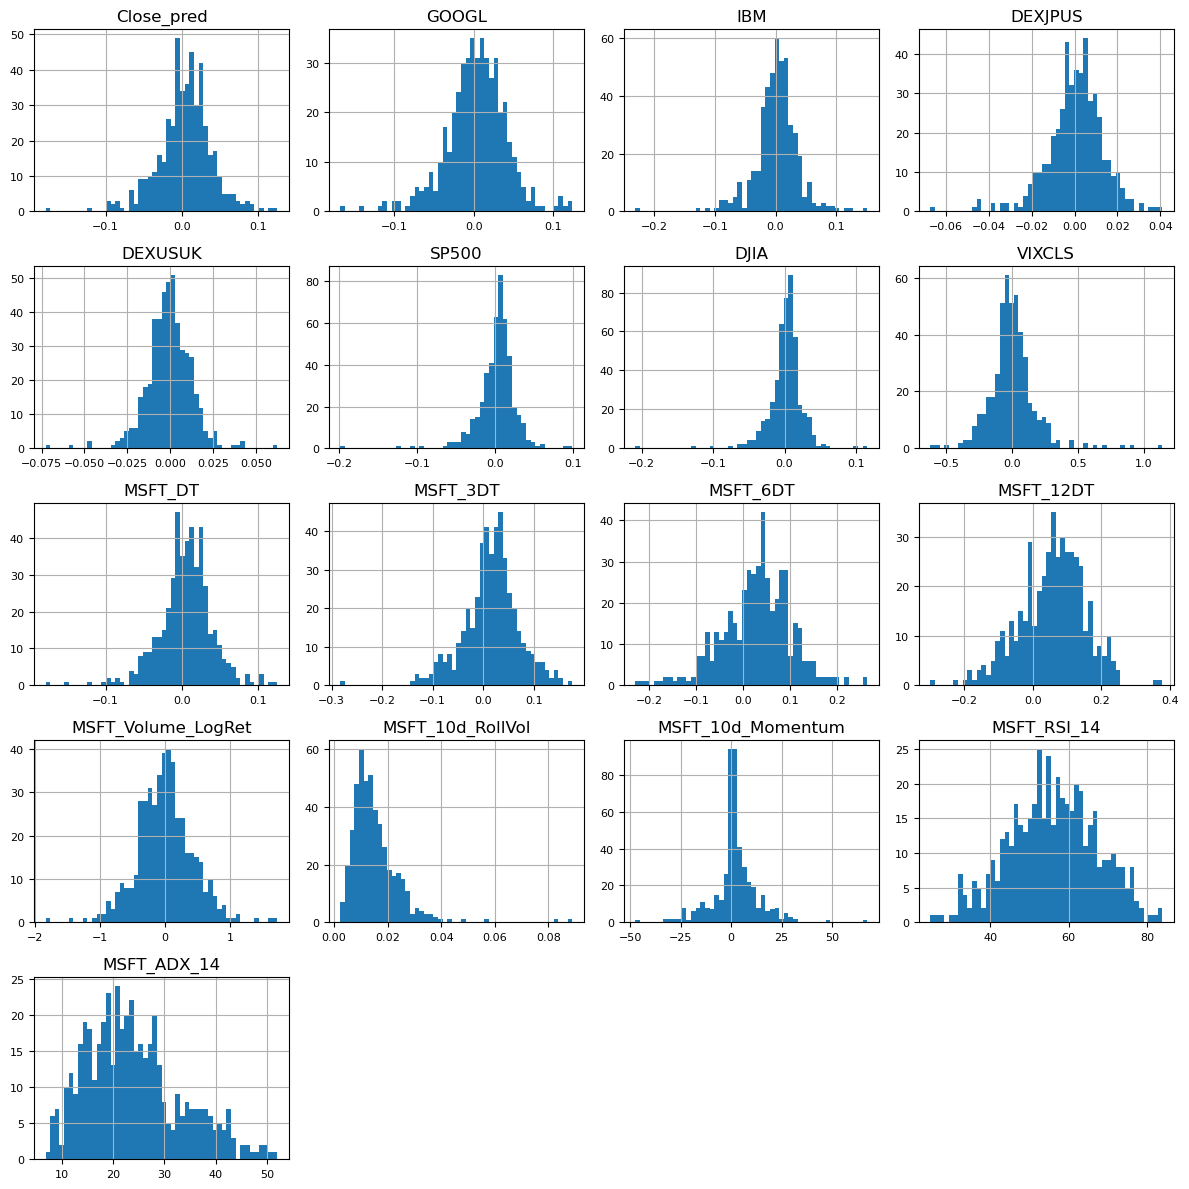

In [8]:
# Visualizing the Histogram of each feature
dataset.hist(bins=50, sharex=False, sharey=False, xlabelsize=8, ylabelsize=8, figsize=(12, 12))
plt.tight_layout()
plt.show()

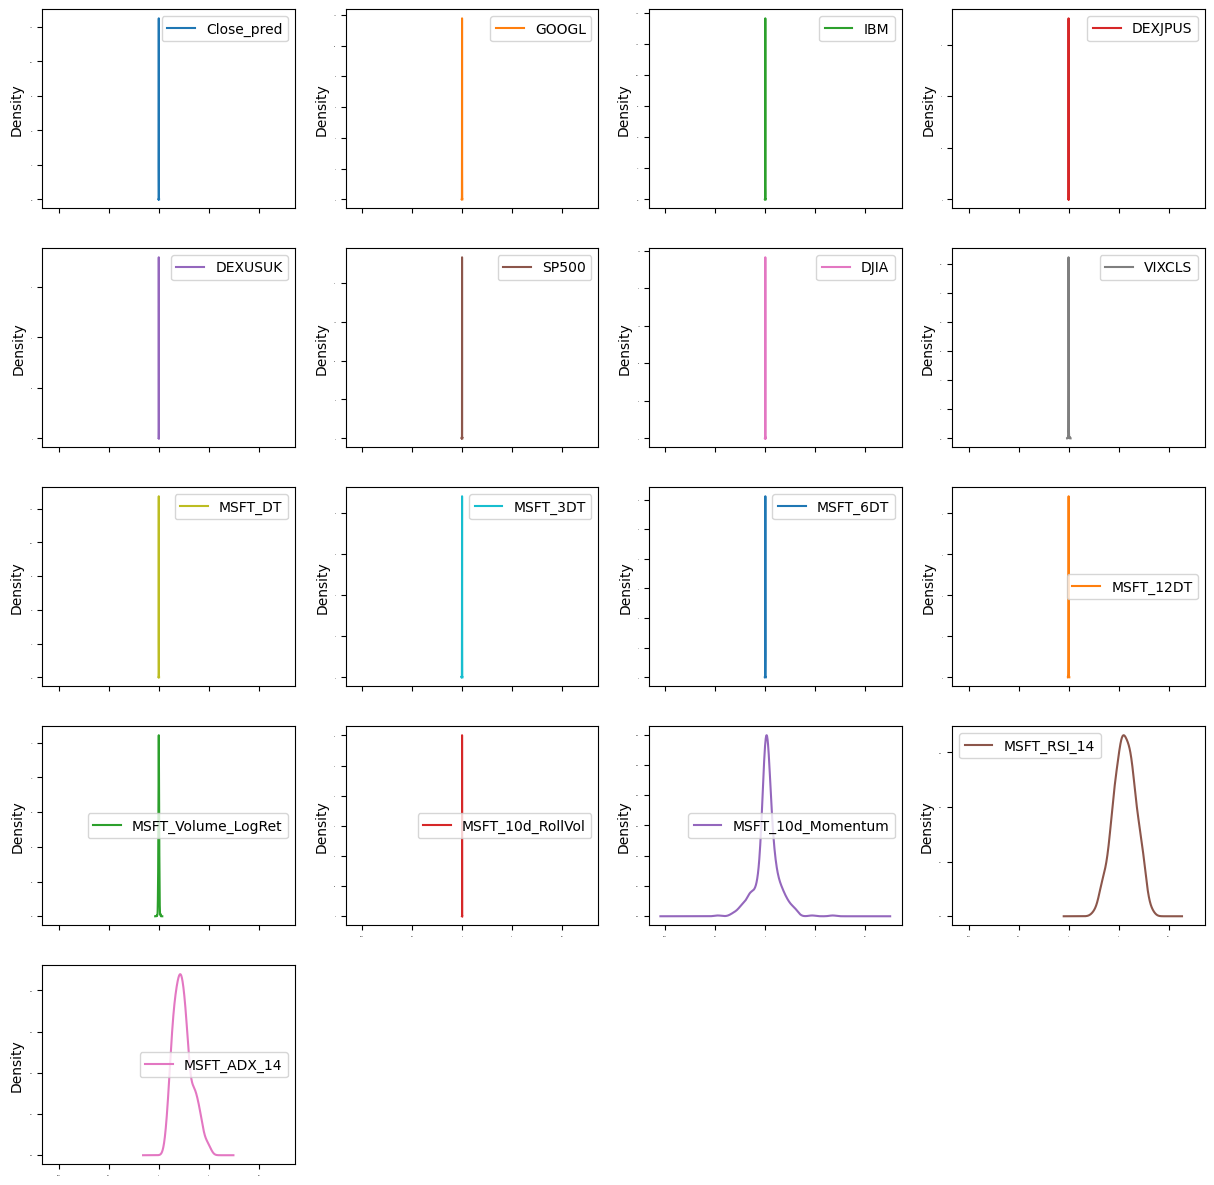

In [9]:
# Visualizing the Density of each feature
dataset.plot(kind='density', subplots=True, layout=(5,4), sharex=True, legend=True, fontsize=1, figsize=(15,15))
plt.savefig("feature_densities.png", dpi=300, bbox_inches='tight')
plt.show()

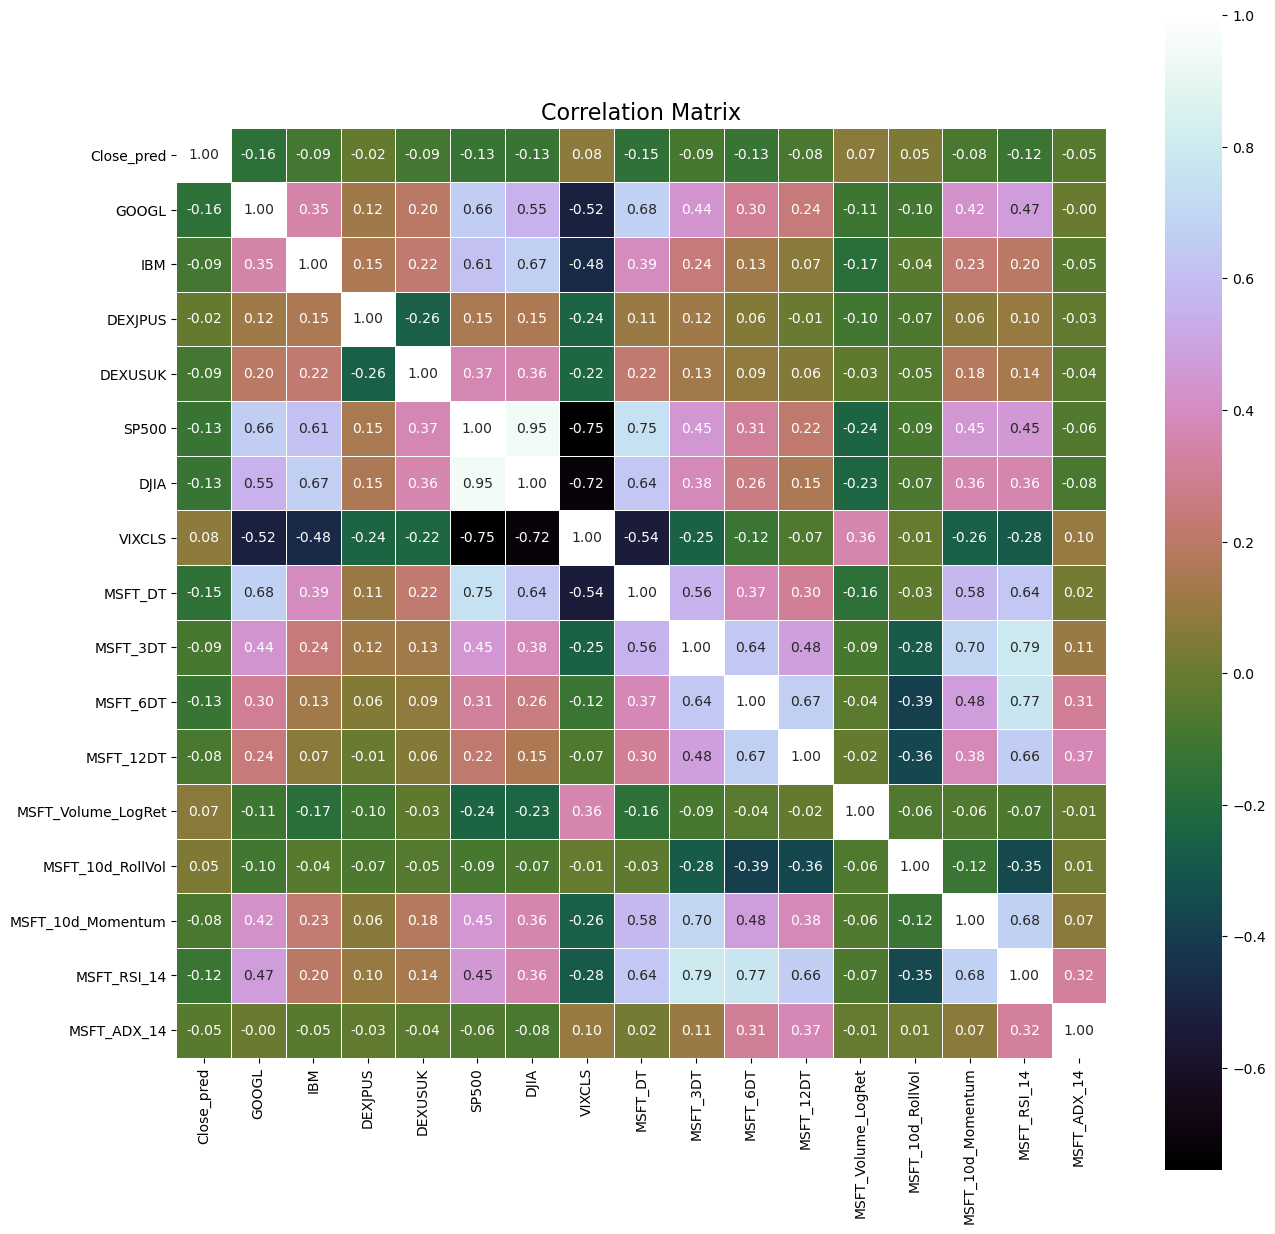

In [10]:
# Computing the correlation matrix
correlation = dataset.corr()

# Correlation heatmap
plt.figure(figsize=(15, 15))
plt.title('Correlation Matrix', fontsize=16)
sns.heatmap(correlation, vmax=1, square=True, annot=True, cmap='cubehelix', fmt=".2f", linewidths=0.5)
plt.show()


<Figure size 1500x1500 with 0 Axes>

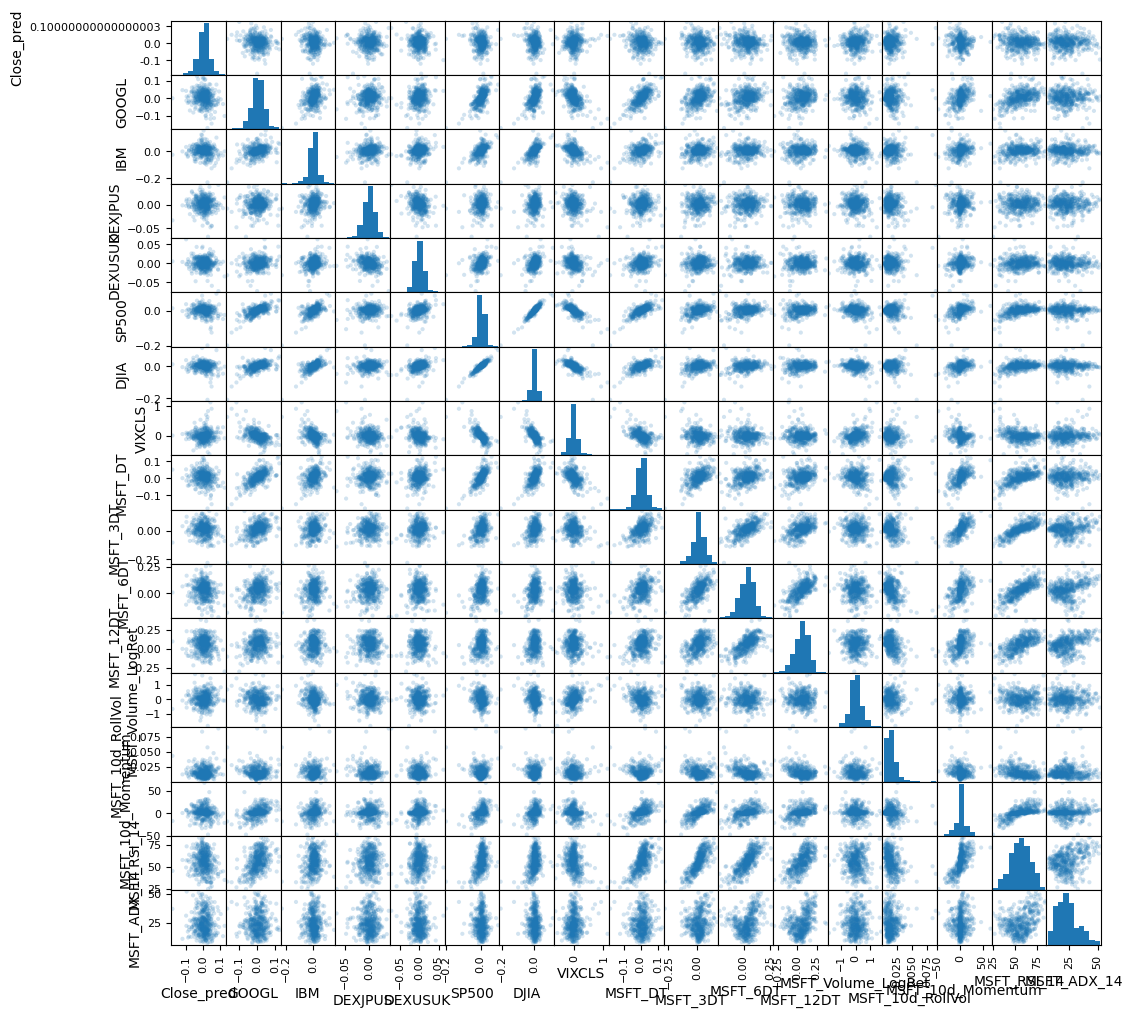

In [11]:
# Setting a large figure size for visibility
plt.figure(figsize=(15, 15))

# Generating the scatter matrix for the dataset
scatter_matrix(dataset, figsize=(12, 12), alpha=0.2)
plt.show()

#### 3.3. Time Series Analysis

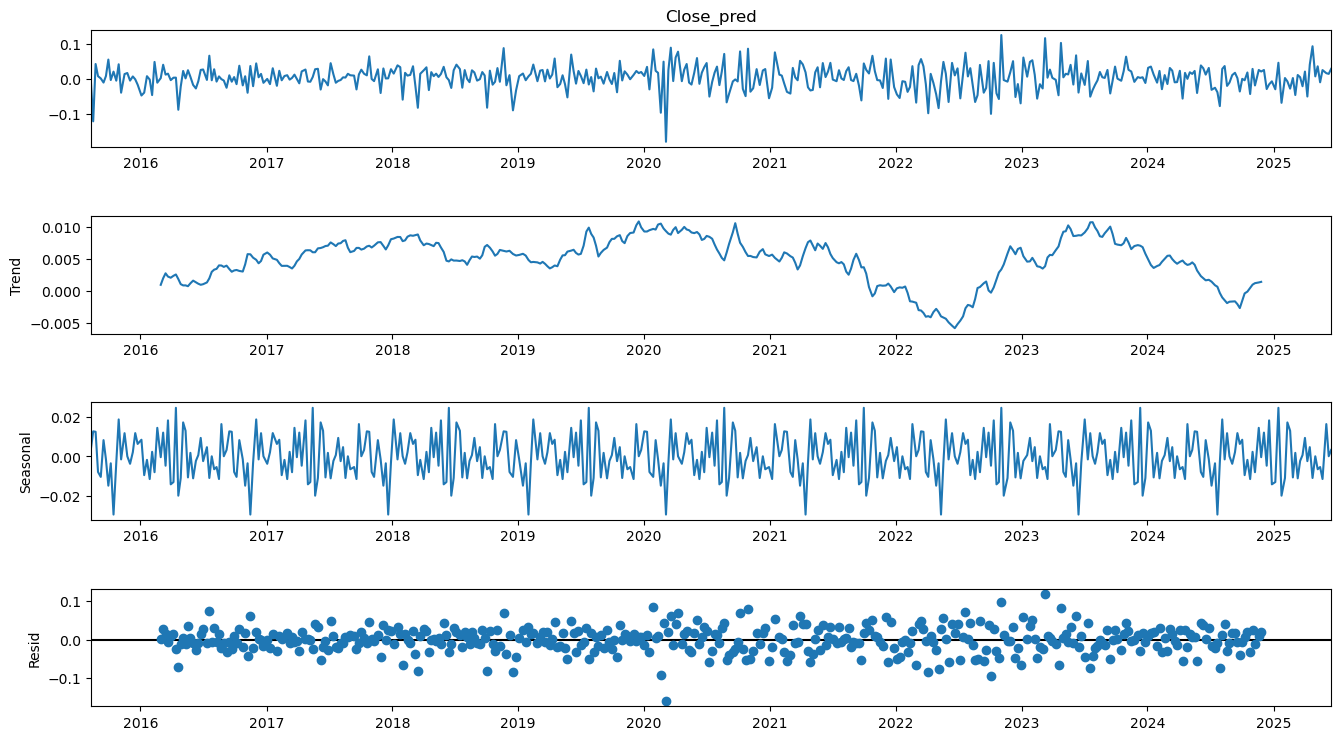

In [12]:
# Ensuring that Y has a datetime index and is a Pandas Series
Y.index = pd.to_datetime(Y.index)

# Decompose assuming weekly data and annual seasonality
res = sm.tsa.seasonal_decompose(Y, model='additive', period=52)

fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
plt.show()

### 4. Data Preparation

#### 4.2. Feature Selection

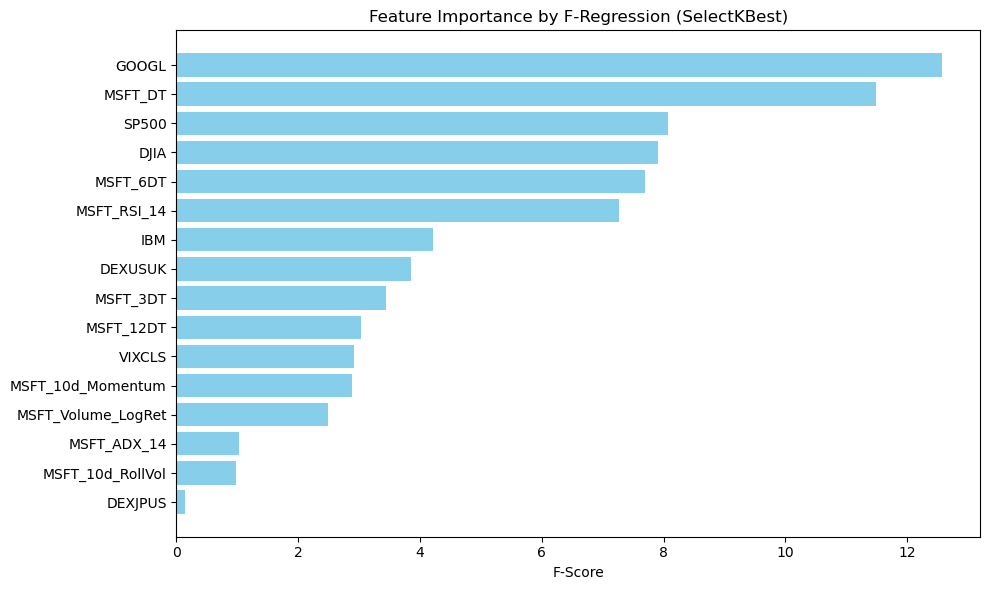

In [13]:
# Select top 5 features based on F-score from univariate regression
bestfeatures = SelectKBest(score_func=f_regression, k=5)
fit = bestfeatures.fit(X, Y)

# Create DataFrame of scores and feature names
dfscores = pd.DataFrame(fit.scores_, columns=['Score'])
dfcolumns = pd.DataFrame(X.columns, columns=['Specs'])

# Compute and display all feature importance scores
featureScores = pd.concat([dfcolumns, dfscores], axis=1)
featureScores.columns = ['Specs', 'Score']

# Sort all features by importance score (descending)
featureScores = featureScores.sort_values(by='Score', ascending=False)

# Visualizing the feature importance
plt.figure(figsize=(10, 6))
plt.barh(featureScores['Specs'], featureScores['Score'], color='skyblue')
plt.xlabel('F-Score')
plt.title('Feature Importance by F-Regression (SelectKBest)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig("feature_importance_fregression.png", dpi=300, bbox_inches='tight')
plt.show()

In [14]:
# Find the worst feature (lowest score)
worst_feature = featureScores.nsmallest(1, 'Score')['Specs'].values[0]

# Drop it from X
X = X.drop(columns=[worst_feature])

print(f"Dropped lowest-scoring feature: {worst_feature}")

Dropped lowest-scoring feature: DEXJPUS


### 5. Evaluate Algorithms and Models

#### 5.1. Train Test Split

In [15]:
# Split dataset chronologically (no shuffle)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, shuffle=False, test_size=0.2)

print(f"Training range: {X_train.index.min()} – {X_train.index.max()}")
print(f"Testing range:  {X_test.index.min()} – {X_test.index.max()}")

Training range: 2015-08-10 00:00:00 – 2023-06-23 00:00:00
Testing range:  2023-07-03 00:00:00 – 2025-06-17 00:00:00


#### 5.2. Test Options and Evaluation Metrics

In [16]:
num_folds = 10
seed = 7
# scikit is moving away from mean_squared_error.
# In order to avoid confusion, and to allow comparison with other models, we invert the final scores
scoring = 'neg_mean_squared_error'

#### 5.3. Model Selection

In [17]:
models = []
# Linear models
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))

# KNN and Tree-based
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))

# SVM
models.append(('SVR', SVR()))

# Neural Networks
models.append(('MLP', MLPRegressor()))

# Ensemble methods - Boosting
models.append(('ABR', AdaBoostRegressor()))
models.append(('GBR', GradientBoostingRegressor()))
models.append(('XGB', XGBRegressor()))

# Ensemble methods - Bagging
models.append(('RFR', RandomForestRegressor()))
models.append(('ETR', ExtraTreesRegressor()))

In [18]:
# Models that require scaling
scale_required = ['LASSO', 'EN', 'KNN', 'SVR', 'MLP']

# Evaluation
names = []
kfold_results = []
test_results = []
train_results = []

for name, model in models:
    names.append(name)

    # Pipeline if scaling is needed
    if name in scale_required:
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('model', model)
        ])
    else:
        pipeline = model

    # K-Fold evaluation
    kfold = KFold(n_splits=num_folds, shuffle=False)
    cv_results = -1 * cross_val_score(pipeline, X_train, Y_train, cv=kfold, scoring=scoring)
    kfold_results.append(cv_results)

    # Train model
    pipeline.fit(X_train, Y_train)
    train_pred = pipeline.predict(X_train)
    test_pred = pipeline.predict(X_test)

    train_result = mean_squared_error(Y_train, train_pred)
    test_result = mean_squared_error(Y_test, test_pred)

    train_results.append(train_result)
    test_results.append(test_result)

    msg = "%s: %f (%f) %f %f" % (name, cv_results.mean(), cv_results.std(), train_result, test_result)
    print(msg)

LR: 0.001380 (0.000785) 0.001228 0.000919
LASSO: 0.001326 (0.000716) 0.001312 0.000850
EN: 0.001326 (0.000716) 0.001312 0.000850
KNN: 0.001471 (0.000699) 0.000982 0.000928
CART: 0.002329 (0.001180) 0.000000 0.002174
SVR: 0.001710 (0.000723) 0.001599 0.001163
MLP: 0.016717 (0.009800) 0.004970 0.008392
ABR: 0.001530 (0.000853) 0.000867 0.000948
GBR: 0.001512 (0.000854) 0.000330 0.000963
XGB: 0.001690 (0.000824) 0.000001 0.001056
RFR: 0.001451 (0.000818) 0.000200 0.000887
ETR: 0.001407 (0.000745) 0.000000 0.000953


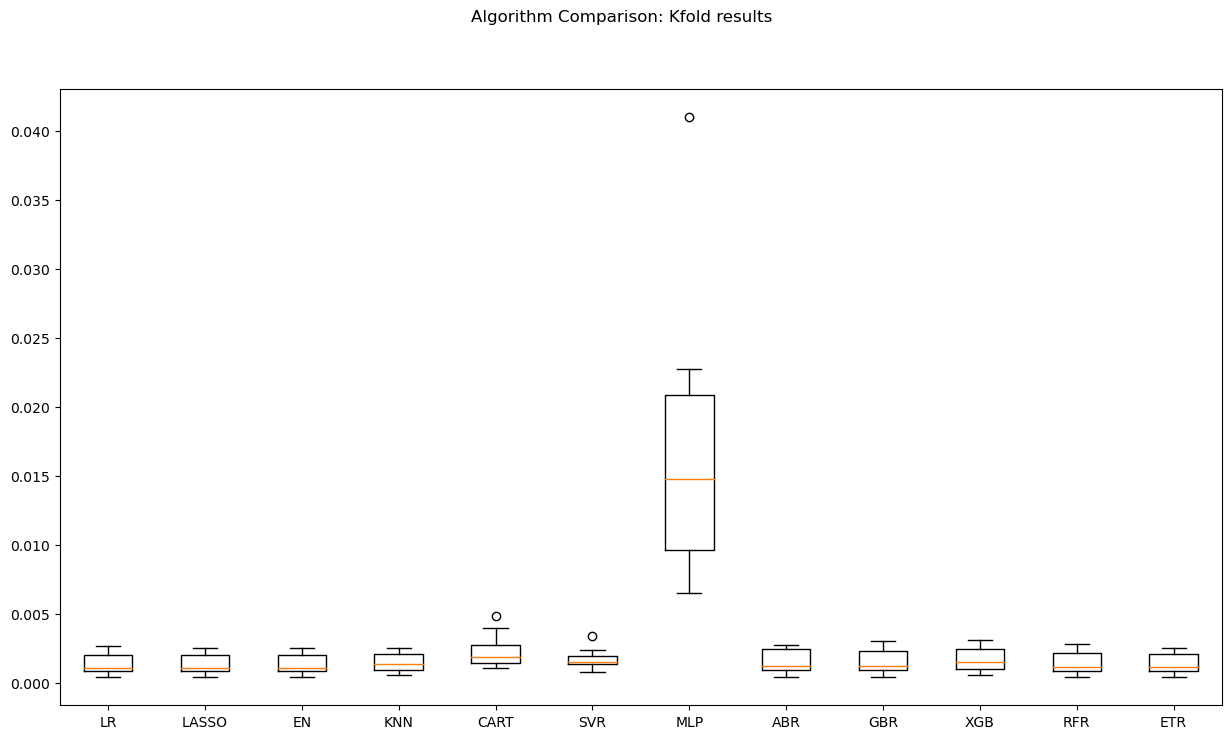

In [19]:
# K-Fold boxplot comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison: Kfold results')
ax = fig.add_subplot(111)
plt.boxplot(kfold_results)
ax.set_xticklabels(names)
fig.set_size_inches(15, 8)
plt.savefig("boxplot_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

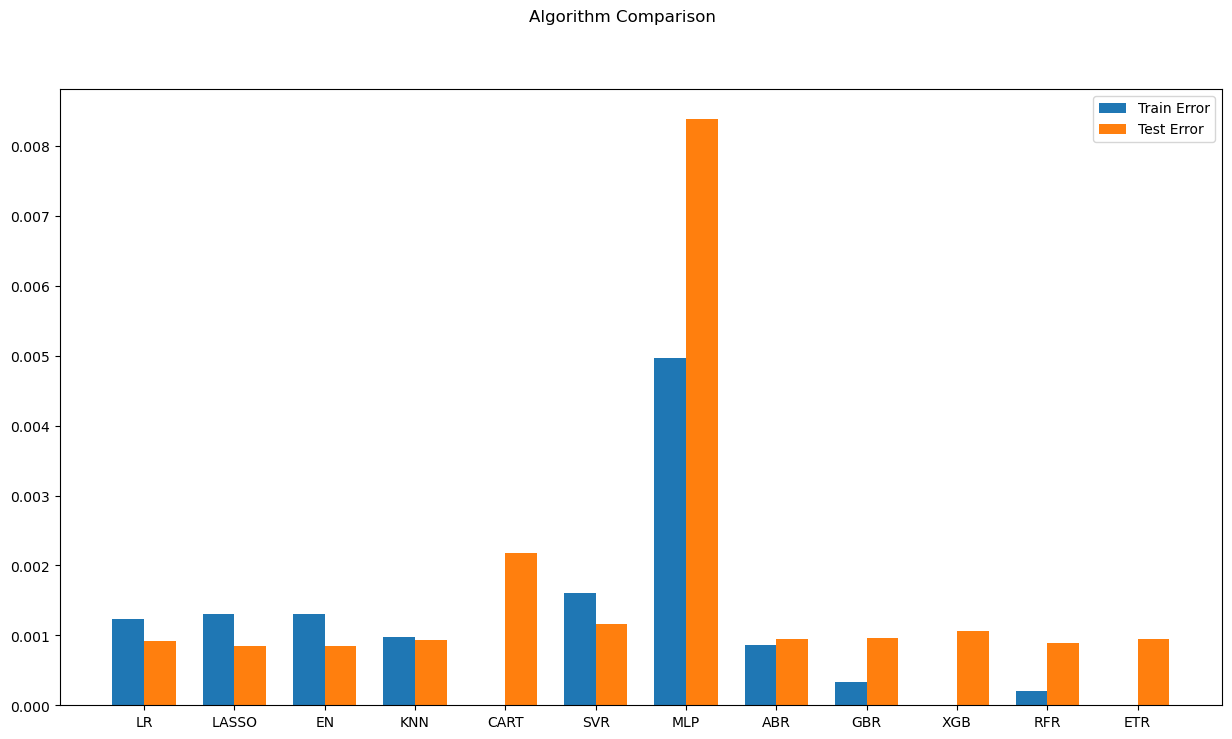

In [20]:
# Compare training and test errors
fig = plt.figure()
fig.suptitle('Algorithm Comparison')

ind = np.arange(len(names))  # the x locations for the groups
width = 0.35  # the width of the bars

ax = fig.add_subplot(111)
plt.bar(ind - width/2, train_results, width=width, label='Train Error')
plt.bar(ind + width/2, test_results, width=width, label='Test Error')

fig.set_size_inches(15, 8)
plt.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
plt.savefig("algorithm_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

### 6. Model Optimization

In [21]:
# Random Forest Regressor was selected as the best model
# Define the parameter grid (corrected leaf values)
param_grid = {'n_estimators': [int(x) for x in np.linspace(10, 20, num=3)],
              'max_features': [round(x, 2) for x in np.linspace(0.3, 1.0, 10)],
              'max_depth': [int(x) for x in np.linspace(2, 10, 10)],
              'min_samples_leaf': list(range(1, 51)),  
              'bootstrap': [True, False]}

# Create base model
rf = RandomForestRegressor(random_state=4)

# Use time-series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Randomized search
rso = RandomizedSearchCV(estimator=rf,
                         param_distributions=param_grid,
                         n_iter=50,  
                         cv=tscv,
                         random_state=4,
                         n_jobs=-1,
                         verbose=1)

# Fit model
rso.fit(X_train, Y_train.ravel())

# Results
print("Best Params:", rso.best_params_)
print("Best CV Score (neg MSE):", rso.best_score_)

# Assign and fit best model
best_random_forest = rso.best_estimator_
best_random_forest.fit(X_train, Y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.3s


Best Params: {'n_estimators': 15, 'min_samples_leaf': 42, 'max_features': 0.38, 'max_depth': 7, 'bootstrap': True}
Best CV Score (neg MSE): 0.0023890619926885794


[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    6.6s finished


RandomForestRegressor(max_depth=7, max_features=0.38, min_samples_leaf=42,
                      n_estimators=15, random_state=4)

In [22]:
# Function to compute Statistical metrics
def regression_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    return {'MSE': mse,
            'MAE': mae}

In [23]:
# Predict returns
Y_pred_train = best_random_forest.predict(X_train)
Y_pred_test = best_random_forest.predict(X_test)

# Train metrics
train_metrics = regression_metrics(Y_train, Y_pred_train)

# Test metrics
test_metrics = regression_metrics(Y_test, Y_pred_test)

# Display results
print("Statistical Metrics")
print("\nTrain Set:")
for k, v in train_metrics.items():
    print(f"{k}: {v:.6f}")

print("\nTest Set:")
for k, v in test_metrics.items():
    print(f"{k}: {v:.6f}")

Statistical Metrics

Train Set:
MSE: 0.001201
MAE: 0.024902

Test Set:
MSE: 0.000861
MAE: 0.022996


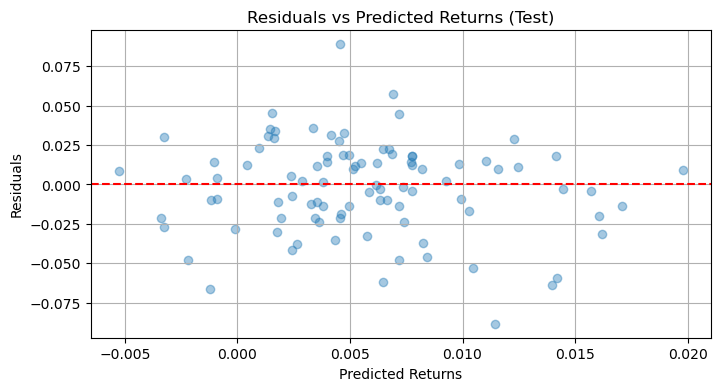

In [24]:
# Residual plot
residuals = Y_test - Y_pred_test
plt.figure(figsize=(8,4))
plt.scatter(Y_pred_test, residuals, alpha=0.4)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Returns')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Returns (Test)')
plt.grid(True)
plt.savefig("residuals_vs_predicted_returns_test.png", dpi=300, bbox_inches='tight')
plt.show()

### 7. Trading Strategy

In [25]:
# Generate trading signals: +1 if predicted return > 0, -1 if < 0
train_signals = np.sign(Y_pred_train)
test_signals = np.sign(Y_pred_test)

# Strategy returns = signal * actual return
train_strategy_returns = train_signals * Y_train.ravel()
test_strategy_returns = test_signals * Y_test.ravel()

In [26]:
# Function to compute Financial metrics
def compute_metrics(log_returns, period=252/5):
    percent_returns = np.exp(log_returns) - 1
    cumulative_return = np.exp(np.sum(log_returns)) - 1
    avg_return = np.mean(percent_returns)
    std_return = np.std(percent_returns)

    # Annualized
    CAGR = (1 + cumulative_return) ** (1 / (len(log_returns)/period)) - 1
    Sharpe = avg_return / std_return * np.sqrt(period) if std_return > 0 else 0

    gains = log_returns[log_returns > 0].sum()
    losses = -log_returns[log_returns < 0].sum()
    ProfitFactor = gains / losses if losses != 0 else np.inf

    return {"Profit Factor": ProfitFactor, 
            "CAGR": CAGR,
            "Sharpe Ratio": Sharpe}

In [27]:
# In-sample
train_metrics = compute_metrics(train_strategy_returns)
print("Financial Metrics")
print("\nIn-sample:")
for k, v in train_metrics.items():
    print(f"{k}: {v:.4f}")

# Out-of-sample
test_metrics = compute_metrics(test_strategy_returns)
print("\nOut-of-sample:")
for k, v in test_metrics.items():
    print(f"{k}: {v:.4f}")

Financial Metrics

In-sample:
Profit Factor: 1.8919
CAGR: 0.5214
Sharpe Ratio: 1.7880

Out-of-sample:
Profit Factor: 1.8535
CAGR: 0.4264
Sharpe Ratio: 1.8558


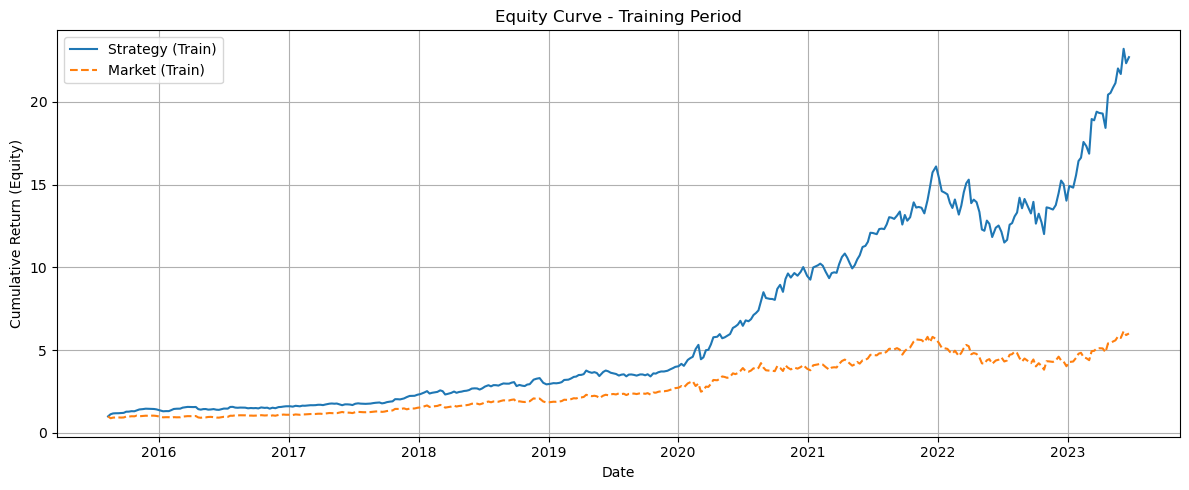

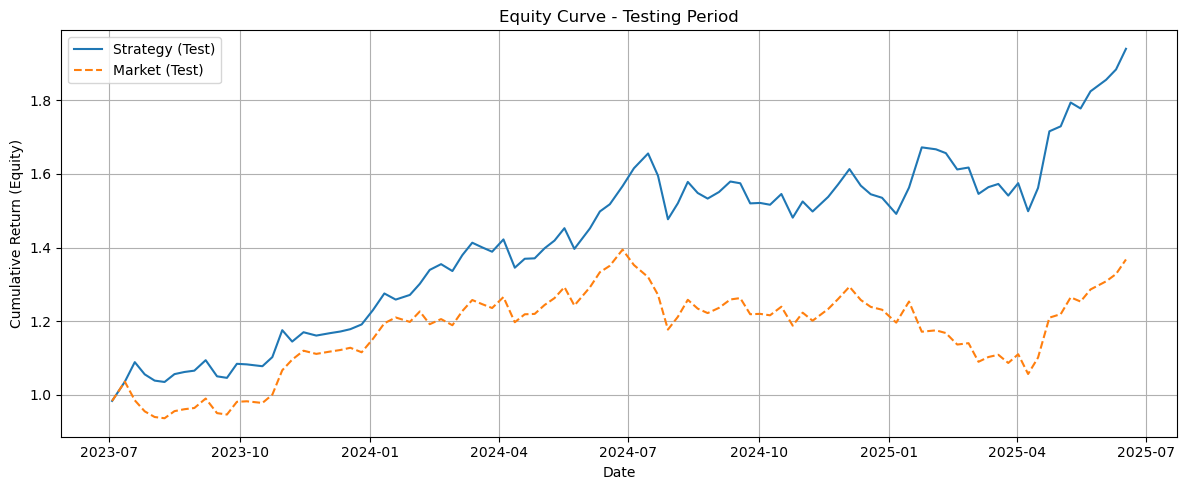

In [28]:
# Equity curves for both training and testing periods
train_dates = X_train.index
test_dates = X_test.index

# Strategy cumulative returns
train_equity = np.exp(np.cumsum(train_strategy_returns))
test_equity = np.exp(np.cumsum(test_strategy_returns))

# Market benchmark: just use actual returns (buy and hold)
train_market_equity = np.exp(np.cumsum(Y_train.ravel()))
test_market_equity = np.exp(np.cumsum(Y_test.ravel()))

# TRAIN equity curve
plt.figure(figsize=(12, 5))
plt.plot(train_dates, train_equity, label='Strategy (Train)')
plt.plot(train_dates, train_market_equity, label='Market (Train)', linestyle='--')
plt.title('Equity Curve - Training Period')
plt.xlabel('Date')
plt.ylabel('Cumulative Return (Equity)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("train_equity_curve.png", dpi=300, bbox_inches='tight')
plt.show()

# TEST equity curve
plt.figure(figsize=(12, 5))
plt.plot(test_dates, test_equity, label='Strategy (Test)')
plt.plot(test_dates, test_market_equity, label='Market (Test)', linestyle='--')
plt.title('Equity Curve - Testing Period')
plt.xlabel('Date')
plt.ylabel('Cumulative Return (Equity)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("test_equity_curve.png", dpi=300, bbox_inches='tight')
plt.show()


### 8. Shap Values

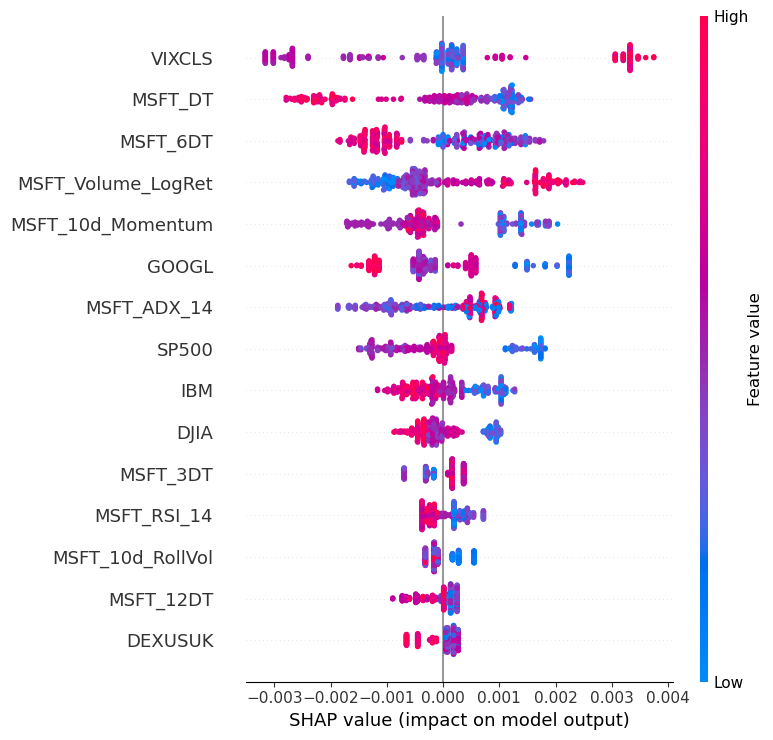

In [29]:
# Visual;izing the shap values of the best model
explainer = shap.TreeExplainer(best_random_forest)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train)

### 9. Evaluating the Results

#### 9.1 White's Reality Check

average return 0.013760
[-0.01438462  0.01419483]
Reject Ho = The population distribution of rule returns has an expected value of zero or less (because p_value is small enough)
p_value:
0.029200000000000004


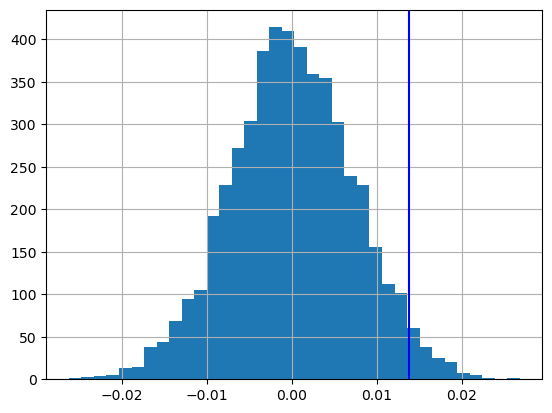

In [30]:
# Detrending MSFT Close price and calculating detrended log returns
msft_close = stk_data.loc[:, ('MSFT', 'Close')]
msft_detrended = detrendPrice.detrendPrice(msft_close)
msft_detrended_logret = np.log(msft_detrended).diff(return_period).shift(-return_period)

# msft_detrended_logret lost its index after diff() and shift(), so re-assign original datetime index:
msft_detrended_logret.index = msft_close.index 

# Align with X_test.index
msft_detrended_logret_test = msft_detrended_logret.loc[test_dates]

detrended_strategy_returns = test_signals * msft_detrended_logret_test
WhiteRealityCheckFor1.bootstrap(detrended_strategy_returns)

#### 9.2 Monte Carlo Permutation

In [31]:
# Select the Profit Factor to evaluate
ProfitFactor = test_metrics['Profit Factor']

# Begin Monte Carlo permutation test
count = 0
num_simulations = 1000

for i in range(num_simulations):
    # Permute the test features (input only, not the target)
    permuted_X = X_test.copy()
    for col in permuted_X.columns:
        permuted_X[col] = np.random.permutation(permuted_X[col].values)
    
    # Predict and generate signals from permuted inputs
    permuted_preds = best_random_forest.predict(permuted_X)
    permuted_signals = np.sign(permuted_preds)
    
    # Align with log returns
    returns_perm = permuted_signals * Y_test
    ProfitFactor_perm = compute_metrics(returns_perm)['Profit Factor']
    
    if ProfitFactor_perm >= ProfitFactor:
        print(f"Permutation {i+1}: PF = {ProfitFactor_perm}")
        count += 1

# Compute final p-value estimate
p_value = (count + 1) / (num_simulations + 1)
print("\nProbability that the model's Profit Factor occurred by chance:", round(p_value, 4))


Permutation 118: PF = 2.008440254706602
Permutation 208: PF = 2.054423263403443

Probability that the model's Profit Factor occurred by chance: 0.003
